# Notebook to develop and test the ABC Rejection on DAP cell model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm

from delfi.distribution import Uniform
from dap.utils import obs_params_gbar, syn_current
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap import DAPcython   
from dap.dap_simulator import DAPSimulator

In [2]:
from dap.cell_fitting.read_heka import (get_sweep_index_for_amp, get_i_inj_from_function,
                                        get_v_and_t_from_heka, shift_v_rest)

In [3]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

### General Settings Pick

In [4]:
n_samples = 100
n_summary = 13
dt = 0.01

### Get current

In [5]:
data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
protocol = 'rampIV' # 'IV' # 'rampIV' # 'Zap20'
ramp_amp = 3.1 # steps of 0.05 -0.15
v_shift = -16  # shift for accounting for the liquid junction potential

sweep_idx = get_sweep_index_for_amp(ramp_amp, protocol)

v, t = get_v_and_t_from_heka(data_dir, protocol, sweep_idxs=[sweep_idx])
v = shift_v_rest(v[0], v_shift)
t = t[0]
I, t_on, t_off = get_i_inj_from_function(protocol, [sweep_idx], t[-1], t[1]-t[0],
                                             return_discontinuities=False)
I=I[0]

In [6]:
params, labels = obs_params_gbar(reduced_model=True)
dap = DAPcython(-75, params*10)

### Set up the model

In [7]:
sim = DAPSimulator(I, dt, -75, dim_param=2)
stats = DAPSummaryStatsMoments(t_on, t_off, n_summary=n_summary)

### Setup Priors

In [8]:
prior_min = np.array([0, 0])
prior_max = np.array([1, 1])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

### generate desired data

In [9]:
U = dap.simulate(dt, t, I)
y_o = {'data': v.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y = stats.calc([y_o])

### sample one parameter, simulate and get the summary statistics

In [10]:
params = prior_unif.gen(n_samples=1)
x_o = sim.gen_single(params[0])
y_obs = stats.calc([x_o])

### calculate appropiate z scores

In [11]:
sum_stats = zscore(y, axis=1)
obs_zt = zscore(y_obs, axis=1)
print('sum_stats', sum_stats[0])
print('obs_zt', obs_zt[0])

sum_stats [-0.48 -0.26 -0.47 -0.26 -0.26 -0.26 -0.26 -0.26  3.45 -0.26 -0.26 -0.25
 -0.15]
obs_zt [-1.95  0.17 -2.22  0.83  0.03  0.25  0.12  0.18  1.78  0.12  0.45  0.01
  0.22]


### distance of the z-scored summary statistics 'sum_stats' to the z-scored observed data 'obs_zt'

In [12]:
dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)
dist_argsort = np.argsort(dist_sum_stats)

## Repeat for 1000 in a loop

In [13]:
n_samples = 1000
eps = 1

In [14]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [15]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)     


100%|██████████| 1000/1000 [08:02<00:00,  2.07it/s]


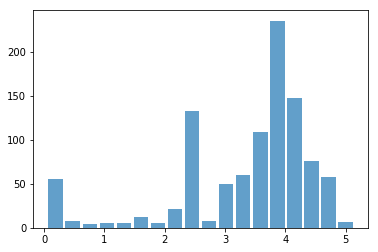

In [16]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [17]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [18]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [19]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

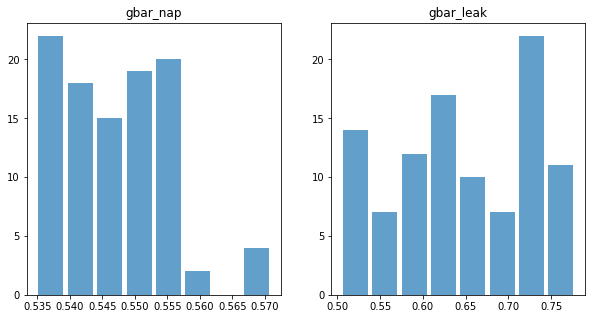

In [20]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

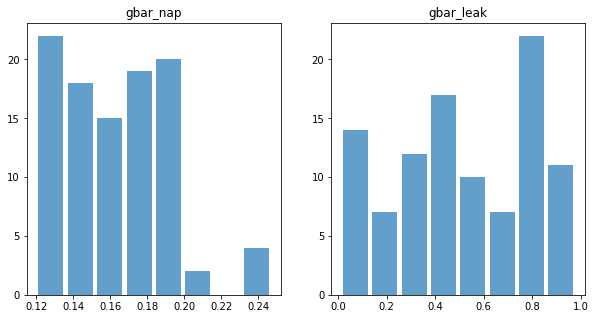

In [21]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

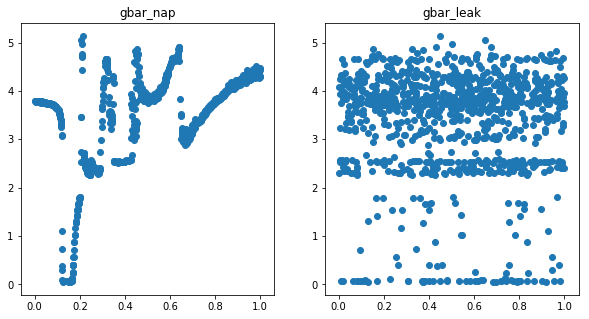

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(params.transpose()[0], scores)
ax[1].scatter(params.transpose()[1], scores)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);


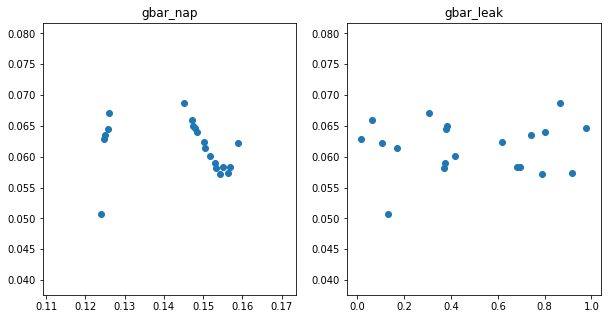

In [23]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(p.transpose()[0], s)
ax[1].scatter(p.transpose()[1], s)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

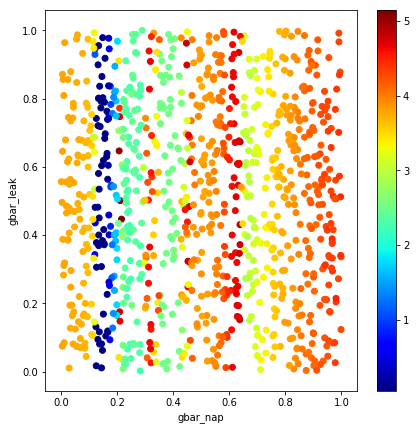

In [24]:
S = np.array([scores]).transpose()
data = np.append(params, S, axis=1)

plt.subplots(1,1,figsize=(7,7))
plt.set_cmap('jet')
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

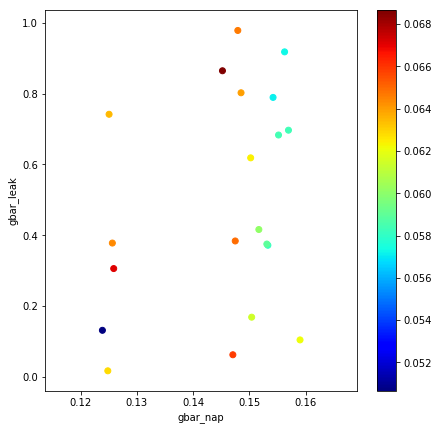

In [25]:
d = np.append(p,  np.array([s]).transpose(), axis=1)

plt.subplots(1,1,figsize=(7,7))
plt.set_cmap('jet')
plt.scatter(d[:,0],d[:,1], c=d[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

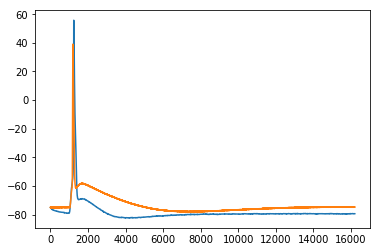

In [26]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
plt.plot(U);
plt.plot(v);

In [27]:
p[0]

array([ 0.12,  0.13])

## Repeat for 5000 in a loop

In [28]:
n_samples = 5000
eps = 1

In [29]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [30]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)     


100%|██████████| 5000/5000 [44:21<00:00,  1.88it/s]


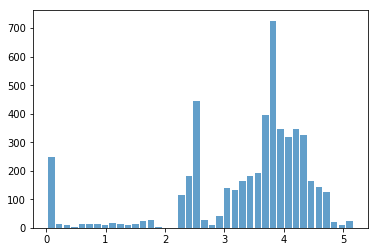

In [31]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [32]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [33]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [34]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

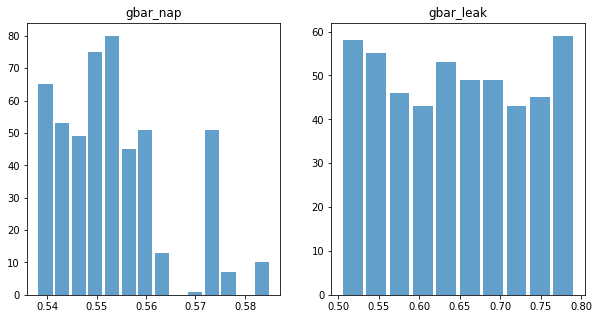

In [35]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

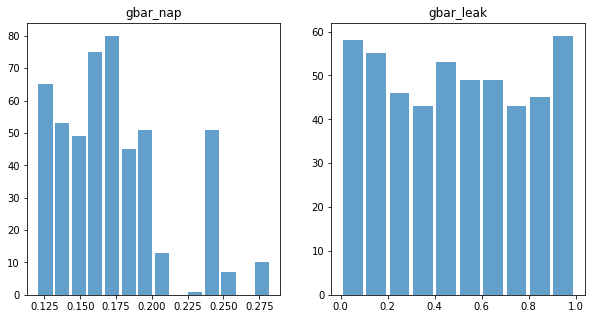

In [36]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

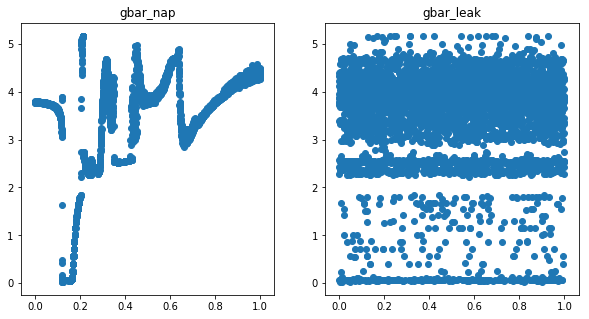

In [37]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(params.transpose()[0], scores)
ax[1].scatter(params.transpose()[1], scores)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);


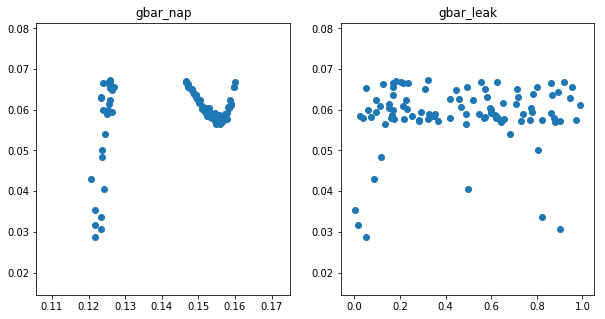

In [38]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(p.transpose()[0], s)
ax[1].scatter(p.transpose()[1], s)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

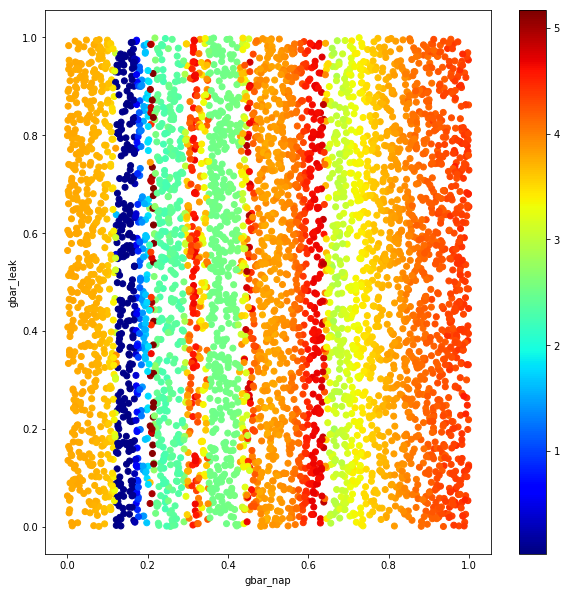

In [39]:
S = np.array([scores]).transpose()
data = np.append(params, S, axis=1)

plt.subplots(1,1,figsize=(10,10))
plt.set_cmap('jet')
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

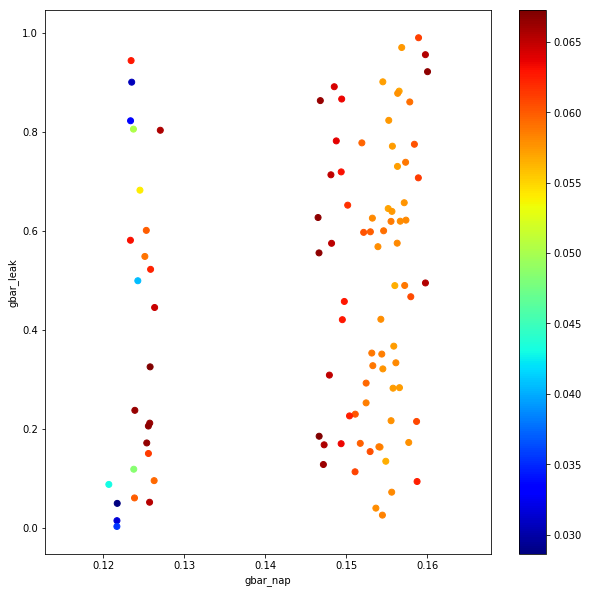

In [40]:
d = np.append(p,  np.array([s]).transpose(), axis=1)

plt.subplots(1,1,figsize=(10,10))
plt.set_cmap('jet')
plt.scatter(d[:,0],d[:,1], c=d[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

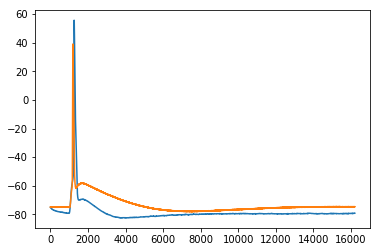

In [41]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
plt.plot(U);
plt.plot(v);

In [42]:
p[0]

array([ 0.12,  0.05])

## Repeat for 8000 in a loop

In [43]:
n_samples = 8000
eps = 1

In [44]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [45]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)     


100%|██████████| 8000/8000 [1:17:26<00:00,  1.72it/s]


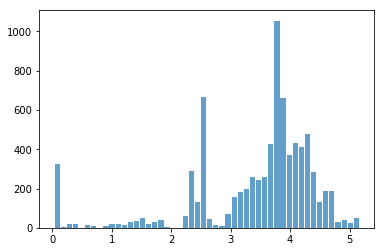

In [46]:
N8 = np.array(norms)
plt.hist(x=N8, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [47]:
scores = N8.transpose()[0]
arg_sorted = np.argsort(scores)

In [48]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [49]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

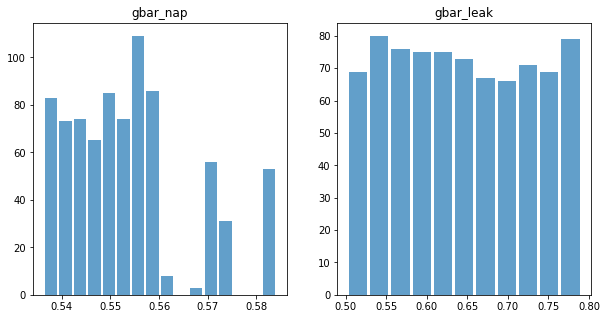

In [50]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

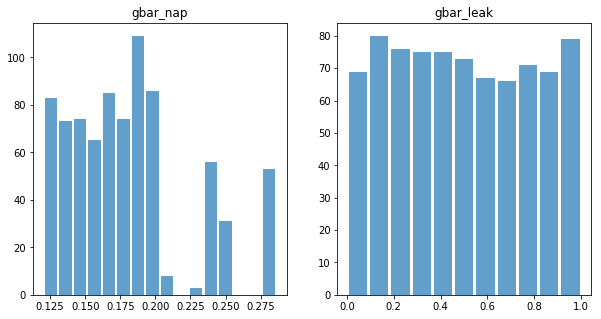

In [51]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

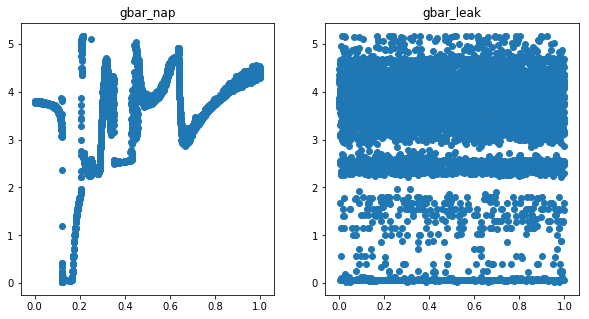

In [52]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(params.transpose()[0], scores)
ax[1].scatter(params.transpose()[1], scores)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);


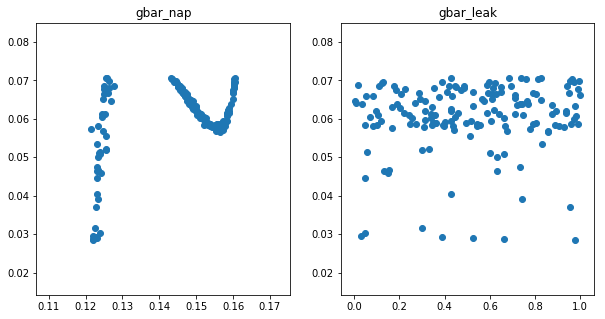

In [53]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(p.transpose()[0], s)
ax[1].scatter(p.transpose()[1], s)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

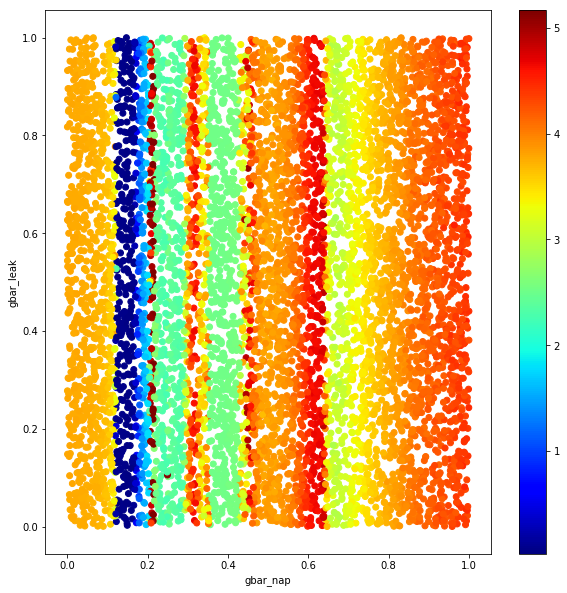

In [54]:
S = np.array([scores]).transpose()
data = np.append(params, S, axis=1)

plt.subplots(1,1,figsize=(10,10))
plt.set_cmap('jet')
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

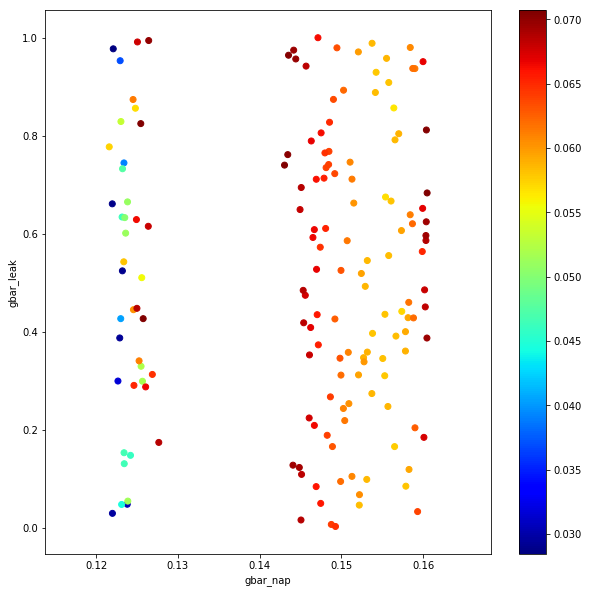

In [55]:
d = np.append(p,  np.array([s]).transpose(), axis=1)

plt.subplots(1,1,figsize=(10,10))
plt.set_cmap('jet')
plt.scatter(d[:,0],d[:,1], c=d[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

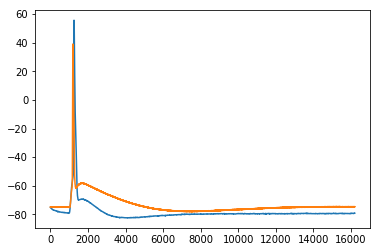

In [56]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
plt.plot(U);
plt.plot(v);

In [57]:
p[0]

array([ 0.12,  0.98])

In [ ]:

X